In [1]:
import os
os.chdir('D:\Birkbeck\MSc Data Science\Year 2\AML\Course work\Coursework Dataset-20211201')
filename = 'train_imperson_without4n7_balanced_data.csv'

In [2]:
# All imports
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function

In [3]:
#Create DF exclude feature 38, see notes and [4]
train = pd.read_csv(filename)
train_data = train.drop(labels = '38', axis =1, inplace = False)
train_data.info()
# train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97044 entries, 0 to 97043
Columns: 152 entries, 1 to 155
dtypes: float64(47), int64(105)
memory usage: 112.5 MB


# Data Preparation

In [4]:
array = train_data.values
X_train = array[ : , 0:151]
y_train = array[ : , 151]

In [5]:
#split into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(77635, 151)


In [6]:
#check that train and test still splits across the target evenly:
print(y_train.sum())
print(y_valid.sum())

38851.0
9671.0


### Normalise Data

In [7]:
norm_scaler = MinMaxScaler(feature_range = (0,1), clip= True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
print(n_X_train.shape)

(77635, 151)


In [8]:
#also need to normalise the validation data for the autoencoder
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_valid.shape)

(19409, 151)


# Variational Autoencoder

In [9]:
#Attempt at Variational Autoencoder
#coding layer is different in  Sampling class used as in Geron book [8] to calculate the mean and log variance in the code layer.

class Sampling(keras.layers.Layer):
    def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean 
    
input_size = 151
code_size = 20

input_data = Input(shape=(input_size,))
hidden_1 = Dense(75, activation='relu')(input_data)
hidden_2 = Dense(35, activation = 'relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(
    input_data, outputs = code)
# code_mean and code_log_variance not included in output, no need to inspect.

decoder_inputs = Input(shape = [code_size])
hidden_3 = Dense(35, activation = 'relu')(decoder_inputs)
hidden_4 = Dense(75, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(inputs = decoder_inputs, outputs =output_data)

code = var_encoder(input_data)
reconst = var_decoder(code)
var_ae = Model(input_data, reconst)

In [10]:
K= keras.backend
#custom loss function for VAE

def losses_func(input_data,reconst):
    latent_loss = -0.5 * K.sum(1 + code_log_var - K.exp(code_log_var) - K.square(code_mean),axis = -1)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data,reconst)
    return (K.mean(latent_loss)/151.) + reconstruction_loss

disable_eager_execution()
var_ae.compile(optimizer = 'adam', loss = losses_func)
history = var_ae.fit(n_X_train, n_X_train, epochs = 10, validation_data=[n_X_valid,n_X_valid])

Train on 77635 samples, validate on 19409 samples
Epoch 1/10
77635/77635 [==============================] - 9s 113us/sample - loss: 0.0686 - val_loss: 0.0521
Epoch 2/10
77635/77635 [==============================] - 8s 100us/sample - loss: 0.0504 - val_loss: 0.0496
Epoch 3/10
77635/77635 [==============================] - 8s 99us/sample - loss: 0.0485 - val_loss: 0.0485
Epoch 4/10
77635/77635 [==============================] - 8s 99us/sample - loss: 0.0476 - val_loss: 0.0473
Epoch 5/10
77635/77635 [==============================] - 8s 98us/sample - loss: 0.0471 - val_loss: 0.0469
Epoch 6/10
77635/77635 [==============================] - 8s 99us/sample - loss: 0.0466 - val_loss: 0.0465
Epoch 7/10
77635/77635 [==============================] - 8s 97us/sample - loss: 0.0464 - val_loss: 0.0469
Epoch 8/10
77635/77635 [==============================] - 8s 100us/sample - loss: 0.0462 - val_loss: 0.0463
Epoch 9/10
77635/77635 [==============================] - 8s 98us/sample - loss: 0.0461 - v

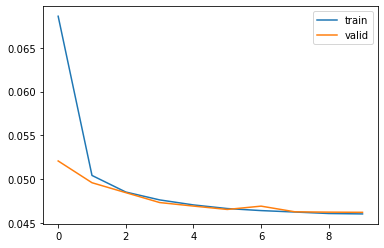

In [67]:
pyplot.plot(history.history['loss'],label = 'train')
pyplot.plot(history.history['val_loss'], label = 'valid')
pyplot.legend()
pyplot.show()         

In [12]:
#The trained encoder contains the reduced features from the code layer.
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

(77635, 20)


In [13]:
#Having a look at the output further:
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000,77635.000000
mean,0.007975,-0.014686,-0.007167,-0.011954,-0.002431,0.004256,-0.002721,-0.005618,0.009899,-0.014758,0.040330,-0.026863,0.004052,0.013149,-0.015940,0.001999,0.002420,0.008556,-0.000616,0.002857
std,0.996512,0.998149,0.992776,1.025150,0.998242,0.993627,0.994100,1.001477,0.990939,1.003381,1.002986,1.039674,1.004941,1.004675,0.999484,0.992996,1.003375,1.001045,0.995505,1.001547
min,-3.913124,-4.172613,-4.691636,-2.868741,-4.312706,-4.170174,-4.359895,-5.059746,-4.051183,-4.635496,-5.310431,-3.234968,-4.424361,-4.138099,-4.494929,-3.915896,-3.960107,-4.236534,-4.306322,-4.304927
25%,-0.664418,-0.683975,-0.676355,-0.823501,-0.675304,-0.666235,-0.670050,-0.682302,-0.657388,-0.692571,-0.645140,-0.828727,-0.676868,-0.666965,-0.690321,-0.664430,-0.679163,-0.671059,-0.670354,-0.671424
50%,0.010265,-0.010778,-0.005253,-0.035079,0.000632,0.005986,-0.001896,-0.005344,0.009249,-0.017381,0.007542,-0.258150,0.005092,0.013097,-0.011374,0.002759,0.000395,0.002336,-0.003913,0.003248
75%,0.679081,0.655875,0.661702,0.639562,0.667362,0.675464,0.665887,0.671623,0.677310,0.661387,0.745989,0.868696,0.685431,0.687567,0.660342,0.677670,0.687836,0.683942,0.671120,0.678753
max,4.366189,4.441914,4.120115,2.695797,4.643752,4.973356,4.380567,4.174656,4.328950,4.009584,4.438735,3.465535,5.702774,4.739316,4.011050,4.237863,4.123657,4.106179,4.307766,4.159869


As expected from the VAE code layer, the generated features have a mean of zero and a standard deviation of 1. 

In [14]:
#normalise the generated features and create a dataframe with new column labels to easily identify vs original features

norm_scaler20 = MinMaxScaler(feature_range = (0,1), clip = True).fit(gen_feat)
n_gen_feat = norm_scaler20.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = map(str,[160,161,162,163,164,165,166,167,168,169, 170,171,172,173,174,175,176,177,178,179])
n_gen_feat.columns= new_col_headers
#print(n_gen_feat.head())

In [15]:
#add generated features dataframe to new features dataframe. With correct column/feature labels. 

num_data = open('col labels numeric.csv')
num_lst = []
for label in num_data:
    label = label.rstrip()
    num_lst.append(label)

n_orig_feat = pd.DataFrame(n_X_train, columns = num_lst)
#pd.set_option('display.float_format',  '{:,.4f}'.format)
#print(n_orig_feat.head())
#print(n_orig_feat.shape)

n_all_feat = pd.concat([n_orig_feat,n_gen_feat],axis = 1)
print(n_all_feat.shape)
#pd.set_option('display.max_columns',161)
#print(n_all_feat.head())

(77635, 171)


# Feature Selection

### Variance Threshold Filter

In [16]:
feat_sel = VarianceThreshold()
feat_sel.fit_transform(n_all_feat)
red_feat = pd.DataFrame(feat_sel.transform(n_all_feat))
col_lst = n_all_feat.columns[feat_sel.get_support()]
print(col_lst)
print(len(col_lst))

Index(['5', '6', '8', '9', '14', '15', '16', '18', '20', '26', '29', '43',
       '47', '48', '50', '51', '52', '61', '62', '64', '66', '67', '68', '70',
       '71', '72', '73', '75', '76', '77', '78', '79', '80', '82', '83', '84',
       '86', '88', '89', '90', '93', '94', '97', '98', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '117', '118', '119',
       '120', '121', '122', '123', '125', '126', '127', '128', '129', '130',
       '133', '138', '140', '141', '142', '143', '144', '145', '146', '154',
       '160', '161', '162', '163', '164', '165', '166', '167', '168', '169',
       '170', '171', '172', '173', '174', '175', '176', '177', '178', '179'],
      dtype='object')
97


In [17]:
red_feat.columns = col_lst
red_feat.shape
#red_all_feat.head()

(77635, 97)

### Kbest with Chi2 Filter

In [18]:
kbest = SelectKBest(score_func = chi2, k =30)
kbest_out = kbest.fit_transform(red_feat, y_train)
kbest_out = red_feat.columns[kbest.get_support()]
print(kbest_out)

Index(['8', '9', '47', '50', '51', '66', '67', '68', '70', '71', '73', '77',
       '82', '94', '107', '110', '121', '122', '126', '127', '128', '129',
       '130', '140', '143', '145', '146', '154', '163', '171'],
      dtype='object')


In [19]:
red_feat2 = pd.DataFrame(kbest.transform(red_feat))
red_feat2.columns = kbest_out
red_feat2.shape
#red_feat2.head()

(77635, 30)

### Kbest with MI Filter

In [20]:
kbest_mi = SelectKBest(score_func = mutual_info_classif, k = 15)
kbest_mi_out = kbest_mi.fit_transform(red_feat2 , y_train)
kbest_mi_out = red_feat2.columns[kbest_mi.get_support()]
print(kbest_mi_out)

Index(['8', '9', '47', '50', '51', '66', '67', '68', '71', '77', '82', '140',
       '154', '163', '171'],
      dtype='object')


In [21]:
X_train_final = pd.DataFrame(kbest_mi.transform(red_feat2))
X_train_final.columns = kbest_mi_out
X_train_final.shape
#X_train_final.head()


(77635, 15)

In [22]:
#checking - correlation function from [12] for future addition to process. Not used in this model

def pairwise_corr(df, threshold = 0.9):
    
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix,dtype = bool))
    reduced_matrix = matrix.mask(mask)
    col_to_drop = [col for col in reduced_matrix.columns if any (reduced_matrix[col] > threshold)]
    return col_to_drop

corr_columns = pairwise_corr(X_train_final, 0.95)
X_train_corr = X_train_final.drop(corr_columns, axis = 1)
print(X_train_corr.shape)

(77635, 13)


In [23]:
print(corr_columns)

['8', '9']


# Selecting Algorithms

### Initial Exploration of Possible Algorithms - no tuning

In [24]:
#compare algs as in lab:
array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

# prepare models
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ET', ExtraTreesClassifier(random_state = 3)))
models.append(('NB', GaussianNB()))
models.append(('LSVC', LinearSVC(random_state = 3)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)


LR: 0.977214 (0.001372)
LDA: 0.957622 (0.001666)
QDA: 0.897976 (0.146554)
KNN: 0.997785 (0.000426)
ET: 0.999820 (0.000175)
NB: 0.981168 (0.002130)
LSVC: 0.978657 (0.001423)


**Notes on results:**

LR - performs well and trains quickly. Assumes linearity. ***EXPLORE FURTHER/TUNE***

LDA/QDA - not good enough. 

KNN performs well but takes too long to run. (requires the whole dataset to be stored?)

Extra trees - performs too well, likely overfitting, wont peform well on test. Extra trees supposed to reduce overfitting. 

NB - simple and performs well. good candidate alg. ***EXPLORE FURTHER/TUNE***

Linear SVC perfom well. In [4] a SVM with gradient descent and a linear function was used to reduce the training time. Time is good/quick here.Quicker than ET. ***EXPLORE FURTHER/TUNE***

## Hyperparameter Tuning

### Logistic Regression Tuning


In [25]:
# Parameters available are: penalty, C, solver. 
# penalty and solver linked in that the penalty depends on which solver.

param_grid = [
    {'solver':['lbfgs','liblinear','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['l1'],'solver':['liblinear','saga'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['none'],'solver':['lbfgs','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
]

lr_model = LogisticRegression()

lr_search = RandomizedSearchCV(lr_model, param_grid ,random_state = 3, cv = 5)
lr_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'solver': ['lbfgs', 'liblinear', 'sag',
                                                    'saga', 'newton-cg']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['l1'],
                                         'solver': ['liblinear', 'saga']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['none'],
                                         'solver': ['lbfgs', 'sag', 'saga',
                                                    'newton-cg']}],
                   random_state=3)

#### Best results for logistic regression:

In [26]:
lr_search.best_params_

{'solver': 'newton-cg', 'penalty': 'none', 'C': 0.08}

In [27]:
lr_search.best_estimator_

LogisticRegression(C=0.08, penalty='none', solver='newton-cg')

In [28]:
lr_search.best_score_

0.9790429574289947

This score is an improvement on the initial exploration of models above

### NB Tuning

In [29]:
# smoothing default at 1e-9.

param_grid3 = [
    {'var_smoothing': [1e-10,1e-9,1e-7,1e-5]},
    ]

nb_model = GaussianNB()

nb_search = RandomizedSearchCV(nb_model,param_grid3,random_state =3, cv=5)
nb_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions=[{'var_smoothing': [1e-10, 1e-09, 1e-07,
                                                           1e-05]}],
                   random_state=3)

In [30]:
nb_search.best_params_

{'var_smoothing': 1e-09}

In [31]:
nb_search.best_estimator_

GaussianNB()

In [32]:
nb_search.best_score_

0.9815160687834096

A small improvement on the untuned model

### LSVC Tuning

In [33]:
param_grid3 = [
    {'penalty': ['l1','l2'], 'loss': ['sqaured_hinge','hinge'], 'C':[0.1,0.3,0.5,0.8,1.0,1.2,1.5,2.0]},
    ]

lsvc_model = LinearSVC(random_state = 3)

lsvc_search = RandomizedSearchCV(lsvc_model,param_grid3,random_state =3, cv=5)
lsvc_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=3),
                   param_distributions=[{'C': [0.1, 0.3, 0.5, 0.8, 1.0, 1.2,
                                               1.5, 2.0],
                                         'loss': ['sqaured_hinge', 'hinge'],
                                         'penalty': ['l1', 'l2']}],
                   random_state=3)

In [34]:
lsvc_search.best_params_

{'penalty': 'l2', 'loss': 'hinge', 'C': 1.5}

In [35]:
lsvc_search.best_estimator_

LinearSVC(C=1.5, loss='hinge', random_state=3)

In [36]:
lsvc_search.best_score_

0.9841051072325626

A small improvement on the untuned model

## 3 Models:

In [37]:
# Compare 3 models with tuned parameters.

array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

# prepare models with best parameters output
models3 = []
models3.append(('LR', lr_search.best_estimator_))
models3.append(('NB', nb_search.best_estimator_))
models3.append(('LSVC', lsvc_search.best_estimator_))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models3:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.979030 (0.001293)
NB: 0.981168 (0.002130)
LSVC: 0.984363 (0.000897)


# Reviewing the 3 Models with Various Evaluation Metrics on TEST DATA:

### Transform Validation Set to Use with Evaluation Metrics

In [38]:
#1) Normalise data (done - using already normed validation data, normed at start for VAE)
# n_X_valid = norm_scaler.transform(X_valid)
#2) predict with encoder
X_valid = encoded.predict(n_X_valid)

#3) scale encoder output
X_valid = norm_scaler20.transform(X_valid)

#4) add 20 features from encoder output to normalised full dataset (remember need diff names or will over-write)
X_valid_full = pd.DataFrame(n_X_valid)
X_valid_gen = pd.DataFrame(X_valid)
X_valid_df = pd.concat([X_valid_full,X_valid_gen],axis = 1)

#5) feature selection 1 - variancethreshold
X_valid = feat_sel.transform(X_valid_df)

#6) feature selection 2 - Kbest with chi2
X_valid = kbest.transform(X_valid)

#7) feature selection 2 - Kbest with chi2
X_valid = kbest_mi.transform(X_valid)

X_valid.shape


(19409, 15)

In [39]:
# Validation target class is stored in, check dimensions:
y_valid.shape

(19409,)

## Logistic Regression Further Evaluation

In [40]:
#Create CV scorng function:
def scoring_cv(measure, model, X = X, Y = Y):
    kfold = KFold(n_splits = 10, random_state = 3, shuffle = True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=measure)
    return measure, round(cv_results.mean(),5), round(cv_results.std(),5)

In [41]:
print(scoring_cv('accuracy',lr_search.best_estimator_))
print(scoring_cv('neg_log_loss',lr_search.best_estimator_))
print(scoring_cv('roc_auc',lr_search.best_estimator_))

('accuracy', 0.97903, 0.00129)
('neg_log_loss', -0.06185, 0.00379)
('roc_auc', 0.9974, 0.0003)


AUC: 0.997


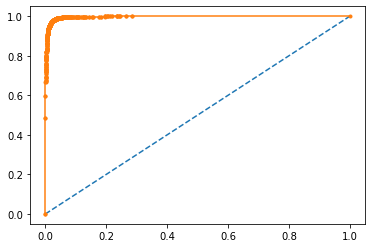

In [42]:
# fit a model (code used from lab)
lr_model = lr_search.best_estimator_
lr_model.fit(X,Y)
# predict probabilities
probs = lr_model.predict_proba(X_valid)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_valid, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_valid, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

Seems pretty good on the validation set. But, how it will perform on the test set?

<AxesSubplot:>

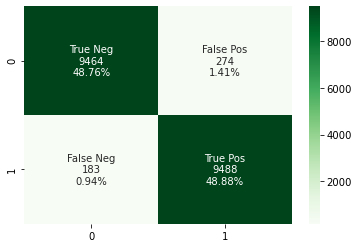

In [43]:
# review a confusion matrix (code used from lab)
lr_predicted = lr_model.predict(X_valid)
lr_matrix = confusion_matrix(y_valid, lr_predicted) 
# print(lr_matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Greens')

Type I error (false alarm) = FP / FP + TN = 248 / 248 + 9490 = 0.02547 (2.5%)

Type II error (miss rate) = FN / FN + TP = 173 / 173 +9498 = 0.01789 (1.8%)

In [44]:
#classification report
lr_report = classification_report(y_valid, lr_predicted) 
print(lr_report)

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      9738
         1.0       0.97      0.98      0.98      9671

    accuracy                           0.98     19409
   macro avg       0.98      0.98      0.98     19409
weighted avg       0.98      0.98      0.98     19409



### Naive Bayes Further Evaluation

In [45]:
print(scoring_cv('accuracy',nb_search.best_estimator_))
print(scoring_cv('neg_log_loss',nb_search.best_estimator_))
print(scoring_cv('roc_auc',nb_search.best_estimator_))

('accuracy', 0.98117, 0.00213)
('neg_log_loss', -0.39884, 0.03902)
('roc_auc', 0.99375, 0.00094)


AUC: 0.993


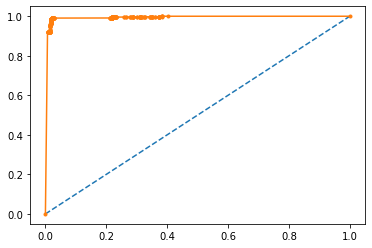

In [46]:
# fit a model
nb_model = nb_search.best_estimator_
nb_model.fit(X,Y)
# predict probabilities
probs = nb_model.predict_proba(X_valid)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_valid, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_valid, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<AxesSubplot:>

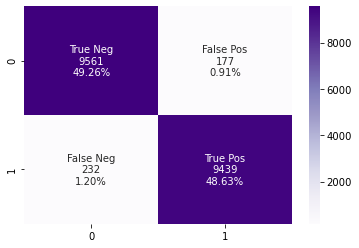

In [47]:
nb_model = nb_search.best_estimator_
nb_model.fit(X,Y)

nb_predicted = nb_model.predict(X_valid)
nb_matrix = confusion_matrix(y_valid, nb_predicted) 
# print(lr_matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in nb_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in nb_matrix.flatten()/np.sum(nb_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_matrix, annot=labels, fmt='', cmap='Purples')

In [48]:
#classification report
nb_report = classification_report(y_valid, nb_predicted) 
print(nb_report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9738
         1.0       0.98      0.98      0.98      9671

    accuracy                           0.98     19409
   macro avg       0.98      0.98      0.98     19409
weighted avg       0.98      0.98      0.98     19409



### LSVC Further Evaluation

In [49]:
print(scoring_cv('accuracy',lsvc_search.best_estimator_))
print(scoring_cv('neg_log_loss',lsvc_search.best_estimator_))
print(scoring_cv('roc_auc',lsvc_search.best_estimator_))

('accuracy', 0.98436, 0.0009)
('neg_log_loss', nan, nan)
('roc_auc', 0.99624, 0.00041)


<AxesSubplot:>

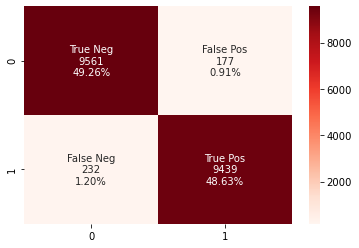

In [50]:
lsvc_model = lsvc_search.best_estimator_
lsvc_model.fit(X,Y)

lsvc_predicted = lsvc_model.predict(X_valid)
lsvc_matrix = confusion_matrix(y_valid, nb_predicted) 
# print(lr_matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lsvc_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lsvc_matrix.flatten()/np.sum(lsvc_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lsvc_matrix, annot=labels, fmt='', cmap='Reds')

In [51]:
#classification report
lsvc_report = classification_report(y_valid, nb_predicted) 
print(lsvc_report)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9738
         1.0       0.98      0.98      0.98      9671

    accuracy                           0.98     19409
   macro avg       0.98      0.98      0.98     19409
weighted avg       0.98      0.98      0.98     19409



#### All models perform well on the validation set

## Apply Models to the test data:

In [52]:
testfile = 'test_imperson_without4n7_balanced_data.csv'

In [53]:
#remove column 38
test = pd.read_csv(testfile)
test_data = test.drop(labels = '38', axis =1, inplace = False)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40158 entries, 0 to 40157
Columns: 152 entries, 1 to 155
dtypes: float64(41), int64(111)
memory usage: 46.6 MB


In [54]:
array = test_data.values
x_test = array[ : , 0:151]
y_test = array[ : , 151]
x_test.shape
#y_test.shape


(40158, 151)

In [55]:
#1) Normalise data 
n_X_test = norm_scaler.transform(x_test)

#2) predict with encoder
X_test = encoded.predict(n_X_test)

#3) scale encoder output
X_test = norm_scaler20.transform(X_test)

#4) add 20 features from encoder output to normalised full dataset (use diff names so doesn't over-write and can add)
X_test_full = pd.DataFrame(n_X_test)
X_test_gen = pd.DataFrame(X_test)
X_test_df = pd.concat([X_test_full,X_test_gen],axis = 1)

#5) feature selection 1 - variancethreshold
X_test = feat_sel.transform(X_test_df)

#6) feature selection 2 - Kbest with chi2
X_test = kbest.transform(X_test)

#7) feature selection 2 - Kbest with chi2
X_test = kbest_mi.transform(X_test)

X_test.shape

(40158, 15)

### Logistic Regression

In [56]:
lr_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, y_test)
lr_score

0.7295931072264555

AUC: 0.971


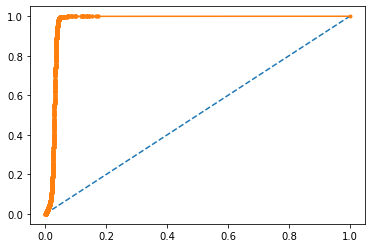

In [57]:
lr_probs = lr_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = lr_probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<AxesSubplot:>

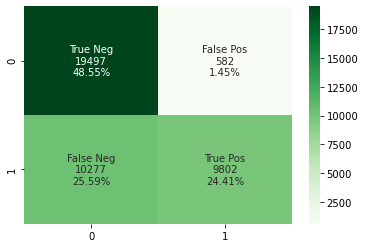

In [58]:
# review a confusion matrix

lr_matrix = confusion_matrix(y_test, lr_pred) 
# print(lr_matrix)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Greens')

In [59]:
#classification report
lr_report = classification_report(y_test, lr_pred) 
print(lr_report)

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78     20079
         1.0       0.94      0.49      0.64     20079

    accuracy                           0.73     40158
   macro avg       0.80      0.73      0.71     40158
weighted avg       0.80      0.73      0.71     40158



## Naive Bayes

In [60]:
nb_pred = nb_model.predict(X_test)
nb_score = nb_model.score(X_test, y_test)
nb_score

0.9785347875890233

AUC: 0.974


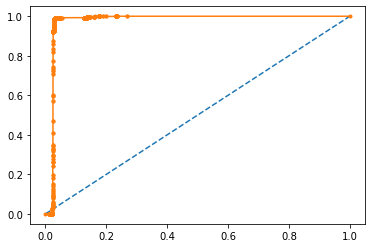

In [61]:
nb_probs =nb_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = nb_probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<AxesSubplot:>

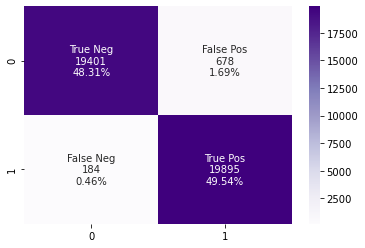

In [62]:
nb_matrix = confusion_matrix(y_test, nb_pred) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in nb_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in nb_matrix.flatten()/np.sum(nb_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_matrix, annot=labels, fmt='', cmap='Purples')

In [63]:
#classification report
nb_report = classification_report(y_test, nb_pred) 
print(nb_report)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     20079
         1.0       0.97      0.99      0.98     20079

    accuracy                           0.98     40158
   macro avg       0.98      0.98      0.98     40158
weighted avg       0.98      0.98      0.98     40158



## Linear SVC

In [64]:
lsvc_pred = lsvc_model.predict(X_test)
lsvc_score = lsvc_model.score(X_test, y_test)
lsvc_score

0.5349120972159969

<AxesSubplot:>

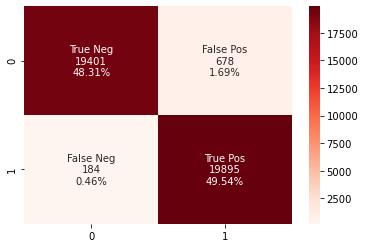

In [65]:
lsvc_matrix = confusion_matrix(y_test, nb_pred) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lsvc_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lsvc_matrix.flatten()/np.sum(lsvc_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lsvc_matrix, annot=labels, fmt='', cmap='Reds')

In [66]:
#classification report
lsvc_report = classification_report(y_test, lsvc_pred) 
print(lsvc_report)

              precision    recall  f1-score   support

         0.0       0.52      0.97      0.68     20079
         1.0       0.78      0.10      0.17     20079

    accuracy                           0.53     40158
   macro avg       0.65      0.53      0.43     40158
weighted avg       0.65      0.53      0.43     40158

